In [1]:
from pathlib import Path
import re
import records
from babel.numbers import parse_decimal, NumberFormatError

schema_re = re.compile(r'\((.+)\)')
num_re = re.compile(r'[-+]?\d*\.\d+|\d+')

db_path = Path("./private")
db = records.Database(f"sqlite:///{db_path / 'kospi.db'}")

테이블 명 확인해보기

In [2]:
db.get_table_names()[-5:]

['363280', '365550', '900140', 'company', 'kospi']

In [20]:
with open("./company_codes.txt", "w", encoding="utf-8") as file:
    for c in db.get_table_names()[:-2]:
        print(c, file=file)

각 Column에 해당하는 의미
- rcept_no: 접수번호
- corp_code: 사업 연도
- stock_code: 종목 코드
- reprt_code: 보고서 코드
- account_nm: 계정명 (예: 자본총계)
- fs_div: 개별/연결구분 ('CFS'=연결재무제표, 'OFS'=재무제표)
- fs_nm: 개별/연결명 ('연결재무제표' 또는 '재무제표')
- sj_div: 재무제표구분 ('BS'=재무상태표, 'IS'=손익계산서)
- sj_nm: 재무제표명 ( '재무상태표' 또는 '손익계산서')
- thstrm_nm: 당기명
- thstrm_dt: 당기일자
- thstrm_amount: 당기금액
- thstrm_add_amount: 당기누적금액
- frmtrm_nm: 전기명
- frmtrm_dt: 전기일자
- frmtrm_amount: 전기금액
- frmtrm_add_amount: 전기누적금액
- bfefrmtrm_nm: 전전기명
- bfefrmtrm_dt: 전전일자
- bfefrmtrm_amount: 전전기금액

테이블 스키마 확인

In [3]:
table_id = "095570"
table_info = db.query('SELECT sql from sqlite_master WHERE tbl_name = :name', name=table_id).all()[0].sql
schema_str = schema_re.findall(table_info.replace("\n", ""))[0]
schema = {}
for tup in schema_str.split(', '):
    c, t = tup.split()
    schema[c.strip('"')] = t
schema

{'index': 'INTEGER',
 'rcept_no': 'TEXT',
 'reprt_code': 'TEXT',
 'bsns_year': 'INTEGER',
 'corp_code': 'TEXT',
 'stock_code': 'TEXT',
 'fs_div': 'TEXT',
 'fs_nm': 'TEXT',
 'sj_div': 'TEXT',
 'sj_nm': 'TEXT',
 'account_nm': 'TEXT',
 'thstrm_nm': 'TEXT',
 'thstrm_dt': 'TEXT',
 'thstrm_amount': 'INTEGER'}

# Data Generation

1. Kospi
2. Company
2. recepts: stock codes

## Table: KOSPI

질문 리스트

- 심볼에 해당하는 회사 이름: `SELECT Name FROM kospi WHERE Symbol = '095570'`
- 섹터:
    - 심볼에 해당하는 섹터는 ? `SELECT Sector FROM kospi WHERE Symbol = '095570'`
    - 이름에 해당하는 섹터는 ? `SELECT Sector FROM kospi WHERE Symbol = 'AJ네트웍스'`
- 산업:
    - 심볼에 해당하는 산업은 ? `SELECT Industry FROM kospi WHERE Symbol = '095570'`
    - 이름에 해당하는 산업은 ? `SELECT Industry FROM kospi WHERE Symbol = 'AJ네트웍스'`
    
반대로는?

- 산업: 
    - XX 업을하는 회사는 어디? `SELECT Name FROM kospi WHERE Sector = '산업용 기계 및 장비 임대업'`
    - XX 업을하는 회사 심볼은? `SELECT Symbol FROM kospi WHERE Sector = '산업용 기계 및 장비 임대업'`

In [4]:
import os
from pyjosa.josa import Josa 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm.notebook import tqdm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
if os.name == "nt":
    print([(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name])
    plt.rcParams["font.family"] = 'NanumBarunGothic'
else:
    if len([(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]) == 0:
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum-gothic/NanumGothic.ttf")
    print([(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name])
    plt.rcParams["font.family"] = 'NanumGothic'

[('NanumBarunGothic', 'C:\\Users\\simon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothicLight.ttf'), ('NanumBarunGothic', 'C:\\Users\\simon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothicBold.ttf'), ('NanumBarunGothic', 'C:\\Users\\simon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothic.ttf'), ('NanumBarunGothic', 'C:\\Users\\simon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothicUltraLight.ttf')]


In [5]:
df_kospi = db.query("SELECT * FROM kospi").export("df")
df_kospi.head()

,index,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,0,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
1,1,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
2,2,027410,KOSPI,BGF,기타 금융업,지주회사,2014-05-19,12월,홍정국,http://www.bgf.co.kr,서울특별시
3,3,282330,KOSPI,BGF리테일,종합 소매업,체인화 편의점,2017-12-08,12월,이건준,http://www.bgfretail.com,서울특별시
4,4,138930,KOSPI,BNK금융지주,기타 금융업,금융지주회사,2011-03-30,12월,김지완,http://www.bnkfg.com,부산광역시


In [6]:
data_path = Path("./newdata") / "total"
if not data_path.exists():
    data_path.mkdir(parents=True)

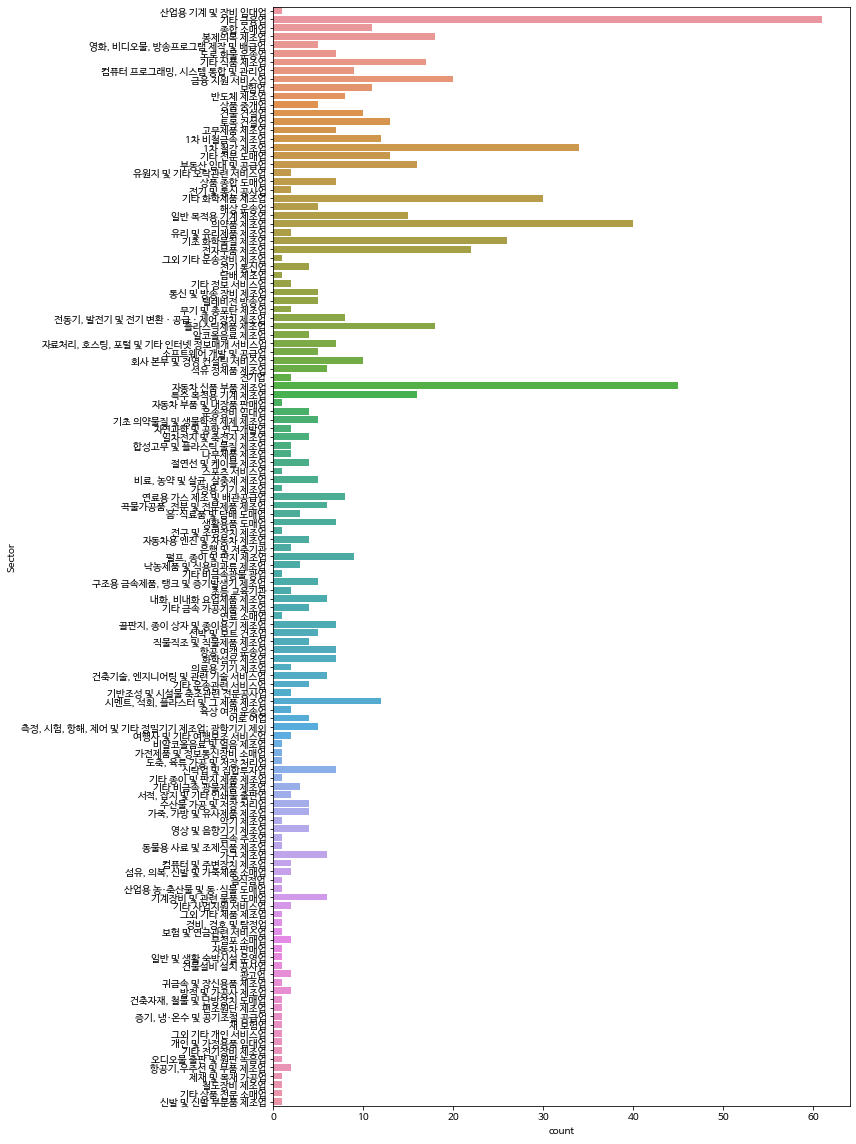

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 16))
sns.countplot(y="Sector", data=df_kospi, ax=ax)
plt.tight_layout()
plt.show()

In [8]:
def create_kospi(df):
    data = []
    symbol_unique = df["Symbol"].unique()
    name_unique = df["Name"].unique()
    cols_1 = ["Name", "Sector", "Industry"]
    logger = tqdm(desc="Creating")
    for col in cols_1:
        if col == "Name":
            for nl_q in ['의 회사 이름이 어떻게 돼?', '의 회사 이름은 뭐야?']:
                for symbol in symbol_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f'SELECT {col} FROM kospi WHERE Symbol = "{symbol}"'
                    data.append(s)
                    logger.update()

        elif col == "Sector":
            for nl_q in [' 회사 무슨 업종이야?', '가 속하는 섹터가 어떻게 돼?', "의 섹터는 뭐야?"]:
                for symbol in symbol_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f'SELECT {col} FROM kospi WHERE Symbol = "{symbol}"'
                    data.append(s)
                    logger.update()
                    
                for name in name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f'SELECT {col} FROM kospi WHERE Name = "{name}"'
                    data.append(s)
                    logger.update()
                    
                    
        elif col == "Industry":
            for nl_q in [' 회사의 산업은?', '가 속하는 산업이 어떻게 돼?']:
                for symbol in symbol_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f'SELECT {col} FROM kospi WHERE Symbol = "{symbol}"'
                    data.append(s)
                    logger.update()
                    
                for name in name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f'SELECT {col} FROM kospi WHERE Name = "{name}"'
                    data.append(s)
                    logger.update()
    
    cols_2 = ["Symbol", "Name"]
    sector_unique = df["Sector"].unique()
    indus_unique = df["Industry"].unique()
    for sec in sector_unique:
        for nl_q in [f"{Josa.get_josa(sec, '을')} 하는 회사는 어디야?", "섹터에 속한 회사들은 뭐가 있어?"]:
            for col in cols_2:
                s = f"{sec}{nl_q}\t"
                s += f'SELECT {col} FROM kospi WHERE Sector = "{sec}"'
                data.append(s)
                logger.update()
    for ind in indus_unique:
        for nl_q in [f"{Josa.get_josa(sec, '을')} 하는 회사는 어디야?", "산업에 속한 회사들은 뭐가 있어?"]:
            for col in cols_2:
                s = f"{ind}{nl_q}\t"
                s += f'SELECT {col} FROM kospi WHERE Industry = "{ind}"'
                data.append(s)
                logger.update()
                
    logger.close()
    return data

In [9]:
kospi_data = create_kospi(df_kospi)

Creating: 0it [00:00, ?it/s]

In [10]:
with (data_path / "kospi.tsv").open("w", encoding="utf-8") as file:
    for line in kospi_data:
        print(line, file=file)

## Table: Company

질문 리스트
- CEO 이름:
    - 심볼에 해당하는 CEO는?  `SELECT ceo_nm FROM kospi WHERE stock_code == '095570'`
    - 이름에 해당하는 CEO는?  `SELECT ceo_nm FROM kospi WHERE stock_name == 'AJ네트웍스'`
    - 영어이름에 해당하는 CEO는?  `SELECT ceo_nm FROM kospi WHERE corp_name_eng == 'AJ Networks Co.,Ltd.'`
- 주소:
    - 심볼에 해당하는 CEO는?  `SELECT adres FROM kospi WHERE stock_code == '095570'`
    - 이름에 해당하는 CEO는?  `SELECT adres FROM kospi WHERE stock_name == 'AJ네트웍스'`
    - 영어이름에 해당하는 CEO는?  `SELECT adres FROM kospi WHERE corp_name_eng == 'AJ Networks Co.,Ltd.'`
- 홈페이지:
    - 심볼에 해당하는 CEO는?  `SELECT hm_url FROM kospi WHERE stock_code == '095570'`
    - 이름에 해당하는 CEO는?  `SELECT hm_url FROM kospi WHERE stock_name == 'AJ네트웍스'`
    - 영어이름에 해당하는 CEO는?  `SELECT hm_url FROM kospi WHERE corp_name_eng == 'AJ Networks Co.,Ltd.'`

In [11]:
df_company = db.query("SELECT * FROM company").export("df")
df_company.head()

,index,corp_name,corp_name_eng,stock_name,stock_code,ceo_nm,corp_cls,jurir_no,bizr_no,adres,hm_url,ir_url,phn_no,fax_no,induty_code,est_dt,acc_mt
0,0,AJ네트웍스 주식회사,"AJ Networks Co.,Ltd.",AJ네트웍스,095570,박대현,Y,1101111874654,2148648586,"서울특별시 송파구 정의로8길 9 (문정동,AJ빌딩)",www.ajnet.co.kr,,02-6363-9999,02-6240-0888,76320,20000210,12
1,1,AK홀딩스(주),"AK Holdings, Inc.",AK홀딩스,006840,"채형석, 이석주(각자 대표이사)",Y,1101110029721,1138110894,서울특별시 마포구 양화로 188 -,www.aekyunggroup.co.kr,,02-768-2923,02-768-2904,64992,19701013,12
2,2,(주)비지에프,"BGF CO., LTD.",BGF,027410,홍정국,Y,1101111105215,1208144752,서울특별시 강남구 테헤란로 405,www.bgf.co.kr,,1577-3663,02-7081398,64992,19941201,12
3,3,(주)비지에프리테일,"BGF retail CO., LTD.",BGF리테일,282330,이건준,Y,1101116555770,8938800792,서울특별시 강남구 테헤란로 405 BGF사옥,www.bgfretail.com,,02-1577-8007,02-528-6820,47122,20171101,12
4,4,(주)BNK금융지주,BNK Financial Group Inc.,BNK금융지주,138930,김지완,Y,1801110750893,6058605385,부산광역시 남구 문현금융로 30(문현동),www.bnkfg.com,,051-620-3023,051-620-3040,64992,20110315,12


In [12]:
def create_company(df):
    data = []
    stock_code_unique = df["stock_code"].unique()
    stock_name_unique = df["stock_name"].unique()
    corp_name_eng_unique = df["corp_name_eng"].unique()
    cols_1 = ["ceo_nm", "adres", "hm_url"]
    logger = tqdm(desc="Creating")
    for col in cols_1:
        if col == "ceo_nm":
            for nl_q in [' 회사의 CEO는 누구야?', ' 회사의 CEO 이름은 뭐야?']:
                for symbol in stock_code_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE stock_code = "{symbol}"'
                    data.append(s)
                    logger.update()
                for name in stock_name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE stock_name = "{name}"'
                    data.append(s)
                    logger.update()
                for eng_name in corp_name_eng_unique:
                    s = f"{eng_name}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE corp_name_eng = "{eng_name}"'
                    data.append(s)
                    logger.update()
        elif col == "adres":
            for nl_q in [' 회사 주소는 뭐야?', ' 회사는 어디에 있어?']:
                for symbol in stock_code_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE stock_code = "{symbol}"'
                    data.append(s)
                    logger.update()
                for name in stock_name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE stock_name = "{name}"'
                    data.append(s)
                    logger.update()
                for eng_name in corp_name_eng_unique:
                    s = f"{eng_name}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE corp_name_eng = "{eng_name}"'
                    data.append(s)
                    logger.update()
        elif col == "hm_url":
            for nl_q in [' 회사의 홈페이지 주소는?', ' 회사의 웹주소가 뭐야?']:
                for symbol in stock_code_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE stock_code = "{symbol}"'
                    data.append(s)
                    logger.update()
                for name in stock_name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE stock_name = "{name}"'
                    data.append(s)
                    logger.update()
                for eng_name in corp_name_eng_unique:
                    s = f"{eng_name}{nl_q}\t"
                    s += f'SELECT {col} FROM company WHERE corp_name_eng = "{eng_name}"'
                    data.append(s)
                    logger.update()
    
    logger.close()
    return data

In [13]:
company_data = create_company(df_company)

Creating: 0it [00:00, ?it/s]

In [14]:
with (data_path / "company.tsv").open("w", encoding="utf-8") as file:
    for line in company_data:
        print(line, file=file)

## Table: 재무제표

질문 리스트

- 리포트 번호:
    - 심볼에 해당하는 xx년도의 리포트 번호?  `SELECT rcept_no FROM '095570' WHERE bsns_year = 2018`
    - 심볼에 해당하는 제 xx 기의 리포트 번호?  `SELECT rcept_no FROM'095570' WHERE thstrm_nm = '제 19 기'`
- 계정명:
    - (계정)명은 어디에 속하는지(재무상태표/손익계산서): `SELECT sj_nm FROM '095570' WHERE account_nm = '유동자산'`
    - 심볼에 해당하는 xx년도의 (계정)은?  `SELECT thstrm_amount FROM '095570' WHERE account_nm = '유동자산' AND bsns_year = 2018`
    - 심볼에 해당하는 제 xx 기의 (계정)은?  `SELECT thstrm_amount FROM '095570' WHERE account_nm = '유동자산' AND thstrm_nm = '제 19 기'`
- 기간:
    - 제 xx 기는 언제를 말하는거지? `SELECT thstrm_dt FROM '095570' WHERE thstrm_nm = '제 19 기'`

In [15]:
# receipts 를 판다스 테이블로 불러옴
df_receipts = db.query("SELECT * FROM '095570'").export("df")
# account_nm 계정명
df_receipts["account_nm"].unique()

array(['유동자산', '비유동자산', '자산총계', '유동부채', '비유동부채', '부채총계', '자본금', '이익잉여금',
       '자본총계', '매출액', '영업이익', '법인세차감전 순이익', '당기순이익'], dtype=object)

In [16]:
df_receipts.head()

,index,rcept_no,reprt_code,bsns_year,corp_code,stock_code,fs_div,fs_nm,sj_div,sj_nm,account_nm,thstrm_nm,thstrm_dt,thstrm_amount
0,0,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,유동자산,제 19 기,2018.12.31 현재,1511355997808
1,1,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,비유동자산,제 19 기,2018.12.31 현재,1063783463551
2,2,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,자산총계,제 19 기,2018.12.31 현재,2575139461359
3,3,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,유동부채,제 19 기,2018.12.31 현재,1609070172105
4,4,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,비유동부채,제 19 기,2018.12.31 현재,474261316507


In [43]:
def create_receipts(df, table_id, logger):
    data = []
    account_unique = df["account_nm"].unique()
    bsns_year_unique = df["bsns_year"].unique()
    thstrm_unique = df["thstrm_nm"].unique()
    report_no_unique = df["rcept_no"].unique()
    
    for term in thstrm_unique:
        for nl_q in ["는 언제를 말하는 거야?", "는 언제야?"]:
            s = f"{table_id}의 {term}{nl_q}\t"
            s += f'SELECT thstrm_dt FROM "{table_id}" WHERE thstrm_nm = "{term}"'
            data.append(s)
            logger.update()
            
    for rpt_no in report_no_unique:
        for nl_q in ['의 접수번호는 뭐야?', ' 의 접수번호는?', '의 보고서 번호가 어떻게 돼?']:
            for bsns_year in bsns_year_unique:
                s = f"{table_id}의 {bsns_year}연도{nl_q}\t"
                s += f'SELECT rcept_no FROM "{table_id}" WHERE bsns_year = {bsns_year}'
                data.append(s)
                logger.update()

            for term in thstrm_unique:
                s = f"{table_id}의 {term}{nl_q}\t"
                s += f'SELECT rcept_no FROM "{table_id}" WHERE thstrm_nm = "{term}"'
                data.append(s)
                logger.update()
        
    for account in account_unique:
        for nl_q in [Josa.get_josa(account, "은") + f" 어느 재무보고서에 속하니?", Josa.get_josa(account, "은") + " 어떤 재무제표야?"]:
            s = f"{account}{nl_q}\t"
            s += f'SELECT sj_nm FROM "{table_id}" WHERE account_nm = "{account}"'
            data.append(s)
            logger.update()
        
        for nl_q in [Josa.get_josa(account, "은") + " 얼마야?", Josa.get_josa(account, "은") + " 어떻게 돼?"]:
            for bsns_year in bsns_year_unique:
            
                s = f"{table_id}의 {bsns_year}연도의 {account}{nl_q}\t"
                s += f'SELECT thstrm_amount FROM "{table_id}" WHERE account_nm = "{account}" AND bsns_year = {bsns_year}'
                data.append(s)
                logger.update()
                
                s = f"{table_id}의 {bsns_year}연도의 {account}{nl_q}\t"
                s += f'SELECT thstrm_amount FROM "{table_id}" WHERE bsns_year = {bsns_year} AND account_nm = "{account}"'
                data.append(s)
                logger.update()
                
                s = f"{bsns_year}년 {table_id}의 {account}{nl_q}\t"
                s += f'SELECT thstrm_amount FROM "{table_id}" WHERE account_nm = "{account}" AND bsns_year = {bsns_year}'
                data.append(s)
                logger.update()
                
                s = f"{bsns_year}년 {table_id}의 {account}{nl_q}\t"
                s += f'SELECT thstrm_amount FROM "{table_id}" WHERE bsns_year = {bsns_year} AND account_nm = "{account}"'
                data.append(s)
                logger.update()
                
            for term in thstrm_unique:
                s = f"{table_id}의 {term} {account}{nl_q}\t"
                s += f'SELECT thstrm_amount FROM "{table_id}" WHERE account_nm = "{account}" AND thstrm_nm = "{term}"'
                data.append(s)
                logger.update()
                
                s = f"{table_id}의 {term} {account}{nl_q}\t"
                s += f'SELECT thstrm_amount FROM "{table_id}" WHERE thstrm_nm = "{term}" AND account_nm = "{account}"'
                data.append(s)
                logger.update()
                
                s = f"{term} {table_id}의 {account}{nl_q}\t"
                s += f'SELECT thstrm_amount FROM "{table_id}" WHERE account_nm = "{account}" AND thstrm_nm = "{term}"'
                data.append(s)
                logger.update()
                
                s = f"{term} {table_id}의 {account}{nl_q}\t"
                s += f'SELECT thstrm_amount FROM "{table_id}" WHERE thstrm_nm = "{term}" AND account_nm = "{account}"'
                data.append(s)
                logger.update()
    return data

In [44]:
receipts_tables = db.get_table_names()[:-2]
data_dist = []
logger = tqdm()
for t in receipts_tables:
    logger.set_description(f"Creating {t}")
    df_receipts = db.query(f'SELECT * FROM "{t}"').export("df")
    receipts_data = create_receipts(df_receipts, t, logger)
    data_dist.append(len(receipts_data))
    with (data_path / f"{t}.tsv").open("w", encoding="utf-8") as file:
        for line in receipts_data:
            print(line, file=file)

0it [00:00, ?it/s]

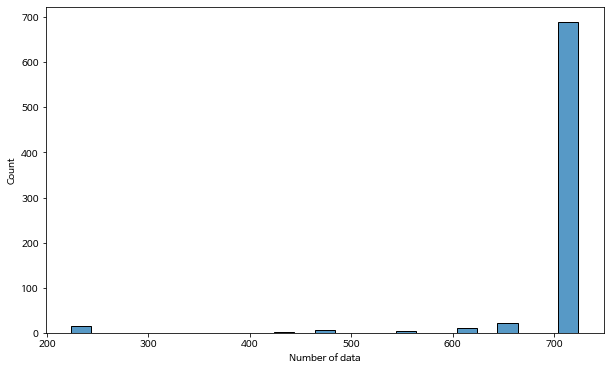

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(data_dist, ax=ax, stat="count", binwidth=20)
ax.set_xlabel("Number of data")
plt.show()

In [47]:
import numpy as np

np.unique(data_dist)

array([224, 242, 436, 470, 560, 610, 660, 710])

# Train Test split by stock code

In [48]:
!rm -rf ./newdata/train
!rm -rf ./newdata/test

In [49]:
data_files = [p for p in data_path.glob("*") if p.name.strip(".tsv") not in ["company", "kospi"]]

split_ratio = 0.85
n_codes = len(receipts_tables)
n_train = int(n_codes * split_ratio)
n_test = n_codes - n_train
print(f"Train: {n_train} / Test: {n_test}")
idxes = np.random.permutation(np.arange(n_codes))
train_idxes, test_idxes = idxes[:n_train], idxes[n_train:]
train_files = np.array(data_files)[train_idxes]
test_files = np.array(data_files)[test_idxes]
print(f"Number of train data pairs: {np.array(data_dist)[train_idxes].sum()}")
print(f"Number of test data pairs: {np.array(data_dist)[test_idxes].sum()}")

Train: 637 / Test: 113
Number of train data pairs: 441248
Number of test data pairs: 78832


In [50]:
# take data that have database
def save_data(path, data):
    if not isinstance(path, Path):
        path = Path(path)
    with path.open("w", encoding="utf-8") as file:
        for line in data:
            print(line, file=file)

if not (data_path.parent / "train").exists():
    (data_path.parent / "train").mkdir(parents=True)
if not (data_path.parent / "test").exists():
    (data_path.parent / "test").mkdir(parents=True)

In [51]:
train_codes = [p.name.strip(".tsv") for p in train_files]
test_codes = [p.name.strip(".tsv") for p in test_files]

df_kospi_selected_train = df_kospi.loc[df_kospi["Symbol"].isin(train_codes)].reset_index(drop=True)
df_kospi_selected_test = df_kospi.loc[df_kospi["Symbol"].isin(test_codes)].reset_index(drop=True)
print(f"Kospi - Train/Test: {len(df_kospi_selected_train), len(df_kospi_selected_test)}")
df_company_selected_train = df_company.loc[df_company["stock_code"].isin(train_codes)].reset_index(drop=True)
df_company_selected_test = df_company.loc[df_company["stock_code"].isin(test_codes)].reset_index(drop=True)
print(f"Company - Train/Test: {len(df_company_selected_train), len(df_company_selected_test)}")

for df, name in zip(
        [df_kospi_selected_train, df_kospi_selected_test, df_company_selected_train, df_company_selected_test],
        ["kospi_train", "kospi_test", "company_train", "company_test"]
    ):
    typ, folder = name.split("_")
    genfunc = create_kospi if typ == "kospi" else create_company
    data = genfunc(df)
    save_data(data_path.parent / folder / f"{typ}.tsv", data)

Kospi - Train/Test: (637, 113)
Company - Train/Test: (637, 113)


Creating: 0it [00:00, ?it/s]

Creating: 0it [00:00, ?it/s]

Creating: 0it [00:00, ?it/s]

Creating: 0it [00:00, ?it/s]

In [54]:
from shutil import copyfile
for x in train_files:
    copyfile(x, data_path.parent / "train" / x.name)
for x in test_files:
    copyfile(x, data_path.parent / "test" / x.name)

In [55]:
train_tables = [x.name.strip(".tsv") for x in (data_path.parent / "train").glob("*.tsv")]
test_tables = [x.name.strip(".tsv") for x in (data_path.parent / "test").glob("*.tsv")]
print(len(train_tables), len(test_tables))

639 115


In [56]:
from dbengine import DBEngine
import jsonlines
dbengine = DBEngine(db_path / 'kospi.db')

In [57]:
def to_jsonl(dbengine, data_path, typ):
    writer = jsonlines.Writer((data_path.parent / typ / f"{typ}.jsonl").open("w"))
    logger = tqdm(desc=f"generating: {typ}.jsonl")
    for x in (data_path.parent / typ).glob("*.tsv"):
        logger.set_postfix_str(x.name)
        with x.open("r", encoding="utf-8") as reader:
            data = [line.strip() for line in reader.readlines()]
        for line in data:
            question, sql = line.split("\t")
            writer.write(dbengine.to_jsonl_sql(sql, question))
            logger.update()
    writer.close()

In [58]:
to_jsonl(dbengine, data_path, typ="train")

generating: train.jsonl: 0it [00:00, ?it/s]

In [59]:
to_jsonl(dbengine, data_path, typ="test")

generating: test.jsonl: 0it [00:00, ?it/s]

In [69]:
with (data_path.parent / "train" / "train.jsonl").open("r", encoding="utf-8") as reader:
    print("Train rows", len(reader.readlines()))
with (data_path.parent / "test" / "test.jsonl").open("r", encoding="utf-8") as reader:
    print("Test rows", len(reader.readlines()))

Train rows 463238
Test rows 82865


## Table

In [63]:
def get_tables(dbengine, data_path, typ):
    tables = [x.name.strip(".tsv") for x in (data_path.parent / typ).glob("*.tsv")]
    logger = tqdm(desc=f"generating: {typ}.tables.jsonl")
    writer = jsonlines.Writer((data_path.parent / typ / f"{typ}.tables.jsonl").open("w"))
    for t in tables:
        table_jsonl = dbengine.to_jsonl_table(t)
        writer.write(table_jsonl)
        logger.update()
    writer.close()

In [64]:
get_tables(dbengine, data_path, "train")

generating: train.table.jsonl: 0it [00:00, ?it/s]

In [65]:
get_tables(dbengine, data_path, "test")

generating: test.table.jsonl: 0it [00:00, ?it/s]

---

# Check Data Loading

In [70]:
from typing import Union, List, Tuple, Dict, Any
import json

def load_data(sql_path: Union[Path, str], table_path: Union[Path, str]) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
    """Load data from path

    Args:
        sql_path (Union[Path, str]): dataset path which contains NL with SQL queries (+answers)
        table_path (Union[Path, str]): table information contains table name, header and values

    Returns:
        Tuple[List[Dict[str, Any]], Dict[str, Any]]: [description]
    """    
    path_sql = Path(sql_path)
    path_table = Path(table_path)

    dataset = load_sqls(path_sql)
    table = load_tables(path_table)

    return dataset, table

def load_sqls(path_sql):
    dataset = []
    with path_sql.open("r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            x = json.loads(line.strip())
            dataset.append(x)
    return dataset

def load_tables(path_table):
    table = {}
    with path_table.open("r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            x = json.loads(line.strip())
            table[x['id']] = x
    return table

In [71]:
sql_path = "./newdata/train/train.jsonl"
table_path = "./newdata/train/train.tables.jsonl"

In [72]:
dataset, table = load_data(sql_path, table_path)

In [73]:
def get_batch_data(data: List[Dict[str, Any]], table: Dict[str, Dict[str, List[Any]]], start_tkn="[S]", end_tkn="[E]", 
                   only_question=False) -> Tuple[List[str], List[str], List[Dict[str, Any]]]:
    """[summary]

    Args:
        data (List[Dict[str, Any]]): [description]
        dbengine (DBEngine): [description]
        start_tkn (str, optional): [description]. Defaults to "[S]".
        end_tkn (str, optional): [description]. Defaults to "[E]".

    Returns:
        Tuple[List[str], List[str], List[Dict[str, Any]]]: [description]
    """    
    batch_qs = [jsonl["question"] for jsonl in data]

    tid = [jsonl["table_id"] for jsonl in data]
    batch_ts = []
    for table_id in tid:
        table_str = f"{table_id}" + "".join([
            f"[COL]{col}" for col in table[table_id]["header"]
        ])
        # TODO: [EXP] Experiment for generate column directly
        # table_str = f"{start_tkn}{table_id}{end_tkn}" + "".join([
        #     f"{col_tkn}{start_tkn}{col}{end_tkn}" for col in dbengine.schema
        # ]) 
        batch_ts.append(table_str)
    if only_question:
        return batch_qs, batch_ts

    batch_sqls = [jsonl["sql"] for jsonl in data]
    return batch_qs, batch_ts, batch_sqls

In [74]:
batch_qs, batch_ts, batch_sqls = get_batch_data(dataset[:5], table, only_question=False)
batch_qs[:5]

['000040의 제 58 기는 언제를 말하는 거야?',
 '000040의 제 58 기는 언제야?',
 '000040의 제 59 기는 언제를 말하는 거야?',
 '000040의 제 59 기는 언제야?',
 '000040의 제 60 기는 언제를 말하는 거야?']

In [75]:
batch_qs, batch_ts = get_batch_data(dataset[:5], table, only_question=True)

In [76]:
batch_qs[:5]

['000040의 제 58 기는 언제를 말하는 거야?',
 '000040의 제 58 기는 언제야?',
 '000040의 제 59 기는 언제를 말하는 거야?',
 '000040의 제 59 기는 언제야?',
 '000040의 제 60 기는 언제를 말하는 거야?']